In [39]:
import numpy as np
from sklearn import metrics, datasets, model_selection, base, tree
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
data = datasets.load_boston().data

In [41]:
y = datasets.load_boston().target

In [42]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, y, test_size=0.25)

Реализуем дерево с MSE критерием, так как у нас задача регрессии

In [44]:
class DecisionTreeRegressor(base.BaseEstimator):
    class Splitter:
        def __init__(self, number_of_feature, border):
            self._number_of_feature = number_of_feature
            self._border = border

        def decide(self, element):
            return element[self._number_of_feature] < self._border

    class Node:
        def __init__(self):
            self._created = False

        def set_as_leaf(self, results):
            self._created = True
            self._leaf = True
            self._result = np.average(results)

        def set_as_intermediate(self, splitter, true, false):
            self._created = True
            self._leaf = False
            self._splitter = splitter
            self._true = true
            self._false = false

        def is_leaf(self):
            assert self._created, "NODE NOT CREATED"
            return self._leaf

        def get_result(self):
            assert self._leaf, "NODE FOR RESULT IS NOT LEAF"
            return self._result

        def get_next(self, element):
            assert not self._leaf, "NODE IS NOT INTERMEDIATE"
            if self._splitter.decide(element):
                return self._true
            else:
                return self._false

    def __init__(self, depth=np.inf, precision=1e-6, number_of_splits=20):
        self._depth = depth
        self._root = None
        self._precision = precision
        self._number_of_splits = number_of_splits

    @staticmethod
    def _criterion(y):
        """mse criterion"""
        if y.size == 0:
            return np.inf
        else:
            return sum((y - y.mean()) ** 2) / y.size

    @staticmethod
    def _split(splitter, X, y):
        """splitting sample by border"""
        data_true = [(x, y_current) for x, y_current in zip(X, y) if splitter.decide(x)]
        data_false = [(x, y_current) for x, y_current in zip(X, y) if not splitter.decide(x)]
        X_true = [x for (x, y_current) in data_true]
        y_true = [y_current for (x, y_current) in data_true]
        X_false = [x for (x, y_current) in data_false]
        y_false = [y_current for (x, y_current) in data_false]
        return np.array(X_true), np.array(y_true), np.array(X_false), np.array(y_false)

    def _quality_of_split(self, splitter, X, y):
        _, y_true, __, y_false = self._split(splitter, X, y)
        return y_true.size * self._criterion(y_true) + y_false.size * self._criterion(y_false)

    def _fit(self, X, y, current_depth):
        current_node = DecisionTreeRegressor.Node()
        if current_depth >= self._depth:
            current_node.set_as_leaf(y)
        elif np.std(y) < self._precision:
            current_node.set_as_leaf(y)
        else:
            best_splitter = None
            H = np.inf
            for feature in xrange(X.shape[1]):
                prev_border = -np.inf
                # choosing border by quantile
                for border in [np.percentile(X[:, feature], x)
                               for x in np.linspace(0, 100, self._number_of_splits)]:
                    if border == prev_border:
                        continue
                    prev_border = border
                    splitter = DecisionTreeRegressor.Splitter(feature, border + 1e-7)
                    current_H = self._quality_of_split(splitter, X, y)
                    if current_H < H:
                        H = current_H
                        best_splitter = splitter

            if best_splitter == None or H == np.inf:
                current_node.set_as_leaf(y)
            else:
                X_true, y_true, X_false, y_false = self._split(best_splitter, X, y)
                true_node = self._fit(X_true, y_true, current_depth + 1)
                false_node = self._fit(X_false, y_false, current_depth + 1)
                current_node.set_as_intermediate(best_splitter, true_node, false_node)
        return current_node

    def _predict(self, element):
        current_node = self._root
        # descent from root to leaf
        while not current_node.is_leaf():
            current_node = current_node.get_next(element)
        return current_node.get_result()

    def fit(self, X_data, y_data):
        self._root = self._fit(X_data, y_data, 0)

    def predict(self, X_data):
        predicted = []
        for x in X_data:
            predicted.append(self._predict(x))
        return np.array(predicted)

In [45]:
sklearn_result = []
for depth in xrange(1, 30):
    sktree = tree.DecisionTreeRegressor(max_depth=depth)
    sktree.fit(X_train, y_train)
    sklearn_result.append(metrics.mean_squared_error(y_test, sktree.predict(X_test)))

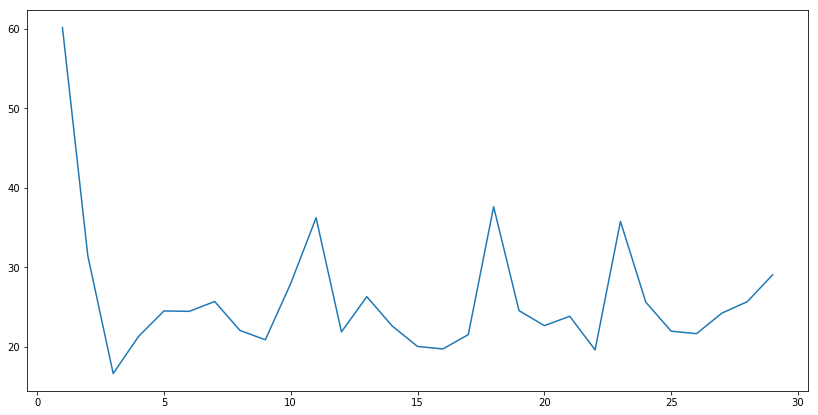

In [48]:
plt.figure(figsize=(14,7))
plt.plot(range(1, 30), sklearn_result)
plt.show()

In [52]:
mytree_result = []
for depth in xrange(1, 30):
    mytree = DecisionTreeRegressor(depth=depth)
    mytree.fit(X_train, y_train)
    mytree_result.append(metrics.mean_squared_error(y_test, mytree.predict(X_test)))

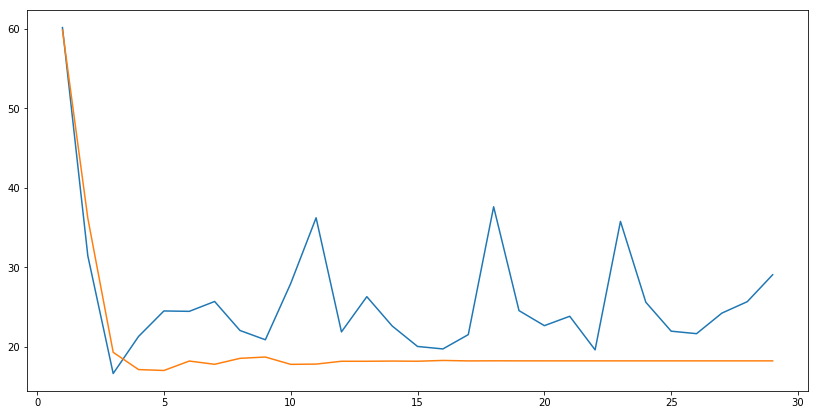

In [53]:
plt.figure(figsize=(14,7))
plt.plot(range(1, 30), sklearn_result)
plt.plot(range(1, 30), mytree_result)

plt.show()

Мое дерево показывает сходное качество с деревом из sklearn, при этом при увеличении глубины в нем не начинаются проблемы с переобучением, скорее всего из-за того что разрешение сетки по которой мы выбираем пороги слишком малое